In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.8.0


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 30

TRAIN_PATH = 'drive/MyDrive/Brain_tumor_detection/T1_brain'

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   validation_split=0.2)


In [6]:
train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 subset = 'training',
                                                 seed=1,
                                                 shuffle = True,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

Found 2044 images belonging to 3 classes.


In [7]:
valid_gen =  train_datagen.flow_from_directory(TRAIN_PATH,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 subset = 'validation',
                                                 seed=1,
                                                 shuffle = False,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

Found 510 images belonging to 3 classes.


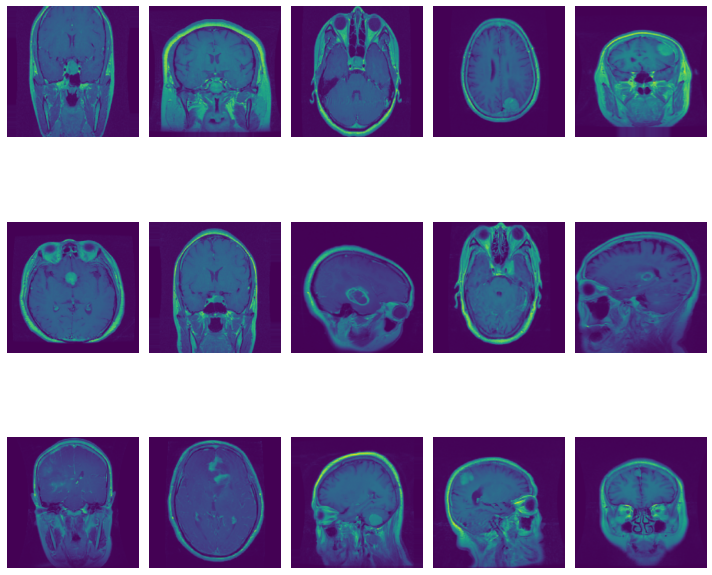

In [ ]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

Only execute this once to install the required stuff

In [8]:
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.2.0-rc3

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0-rc3 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1)
ERROR: No matching distribution found for tensorflow==2.2.0-rc3


In [9]:
!pip install --quiet vit-keras
import tensorflow_addons as tfa

from vit_keras import vit

In [17]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 3)

In [18]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(3, 'softmax')
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 3)                 2307      
                                                                 
Total params: 87,460,611
Trainable params: 87,459,075
Non-trainable params: 1,536
_________________________________________________________________


In [19]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

r = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5')

Epoch 1/30
127/127 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.6213
Epoch 1: val_accuracy improved from -inf to 0.65927, saving model to ./model.hdf5
127/127 [==============================] - 148s 722ms/step - loss: 1.0499 - accuracy: 0.6213 - val_loss: 0.9864 - val_accuracy: 0.6593 - lr: 1.0000e-04
Epoch 2/30
127/127 [==============================] - ETA: 0s - loss: 0.9111 - accuracy: 0.7194
Epoch 2: val_accuracy improved from 0.65927 to 0.67540, saving model to ./model.hdf5
127/127 [==============================] - 92s 725ms/step - loss: 0.9111 - accuracy: 0.7194 - val_loss: 1.0300 - val_accuracy: 0.6754 - lr: 1.0000e-04
Epoch 3/30
127/127 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.7717
Epoch 3: val_accuracy improved from 0.67540 to 0.78226, saving model to ./model.hdf5
127/127 [==============================] - 93s 729ms/step - loss: 0.8259 - accuracy: 0.7717 - val_loss: 0.8521 - val_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 

In [20]:
eval = model.evaluate(valid_gen)
eval

32/32 [==============================] - 15s 458ms/step - loss: 0.7250 - accuracy: 0.8588


[0.7249594926834106, 0.8588235378265381]

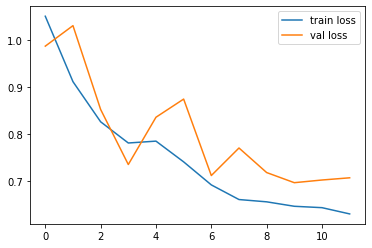

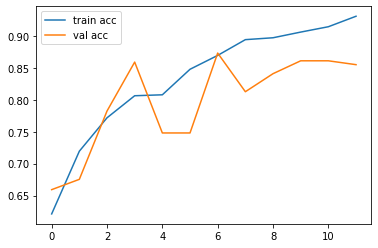

<Figure size 432x288 with 0 Axes>

In [21]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')